In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES = 6 python U-net.ipynb

import torch.nn.functional as F
from torch import nn
import torch
from torch.optim import Adam
import torchvision

import math

from load_segment_dataset import Segmentation_dataset
from model_learning import Train
from UnetBlock import Unet

env: CUDA_VISIBLE_DEVICES=6 python U-net.ipynb


In [2]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
DEVICE = 'cuda'

In [3]:
data = Segmentation_dataset(batch_size=4)
train_loader, val_loader, test_loader = data.get_loaders()
test_dataset, train_dataset = data.get_test_dataset()

In [4]:
data.get_datasets_sizes()

Train size: 20210
Validation size: 1000
Test size: 1000


In [5]:
model = Unet()
model = model.to(DEVICE)
# loss_function = nn.CrossEntropyLoss(ignore_index=150)
optimizer = Adam(params=model.parameters(), lr=LEARNING_RATE)

In [6]:
def crop_images(predicted, masks_or_images):
    """Если выход больше или меньше чем исходное изображение,
    вырезать центральную часть из обоих, чтобы размеры совпадали.
    """
    if len(masks_or_images.shape) == 3:
        predicted, masks = crop_images(predicted, masks_or_images.unsqueeze(1))
        return predicted, masks[:, 0]
    images = masks_or_images
    if (len(predicted.shape) != 4) or (len(images.shape) != 4):
        raise ValueError("Expected tensors of shape BCHW")
    bi, ci, hi, wi = images.shape
    bp, cp, hp, wp = predicted.shape
    offset = (abs(hi - hp) // 2, abs(wi - wp) // 2)
    if hp < hi:
        images = images[:, :, offset[0]:offset[0] + hp]
    else:
        predicted = predicted[:, :, offset[0]:offset[0] + hi]
    if wp < wi:
        images = images[:, :, :, offset[1]:offset[1] + wp]
    else:
        predicted = predicted[:, :, :, offset[1]:offset[1] + wi]
    return predicted, images

class XentLoss(torch.nn.Module):
    """Функция потерь для сегментации с несколькими классами."""
    def __init__(self):
        super().__init__()
        self._xent = torch.nn.CrossEntropyLoss(ignore_index=150)
        
    def __call__(self, predicted, masks):
        predicted, masks = crop_images(predicted, masks)
        b, c, h, w = predicted.shape
        predicted = predicted.permute(0, 2, 3, 1).reshape(b * h * w, c)
        masks = masks.reshape(-1)
        loss = self._xent(predicted, masks)
        return loss

In [7]:
loss_function = XentLoss()

In [8]:
print('parameters:', sum(param.numel() for param in model.parameters()))

parameters: 32669386


In [9]:
learning = Train(model=model, loss_function=loss_function,
                 optimizer=optimizer, num_epochs=NUM_EPOCHS, train_loader=train_loader,
                 val_loader=val_loader, test_loader=test_loader, test_dataset=test_dataset,
                 device=DEVICE)

In [10]:
class Catchtime:
    def __enter__(self):
        self.start = torch.cuda.Event(enable_timing=True)
        self.end = torch.cuda.Event(enable_timing=True)
        self.start.record()
        return self

    def __exit__(self, type, value, traceback):
        self.end.record()
        torch.cuda.synchronize()
        
    def __float__(self):
        
        return self.start.elapsed_time(self.end)

In [11]:

with Catchtime() as unet_time:
    learning.train_procedure(task='segmentation')

print(float(unet_time))

Epoch number is 1
Epoch number is 2
Epoch number is 3
Epoch number is 4
Epoch number is 5
Epoch number is 6
Epoch number is 7
Epoch number is 8
Epoch number is 9
Epoch number is 10
4998615.5


In [12]:
train_losses = learning.get_train_avg_loss()
valid_losses = learning.get_valid_avg_loss()

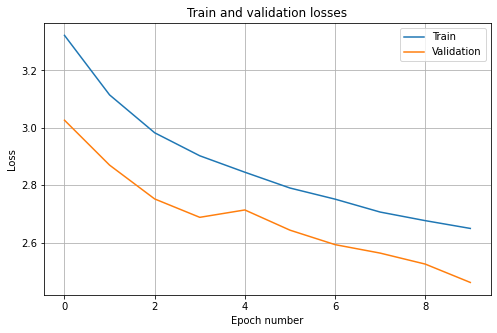

In [13]:
learning.plot_losses(train_losses=train_losses, valid_losses=valid_losses,
            fig_size_width=8, fig_size_height=5)

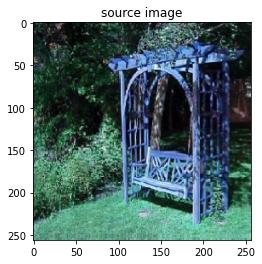

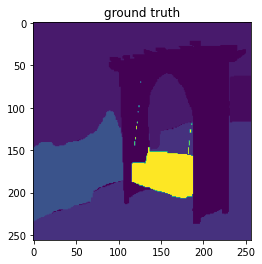

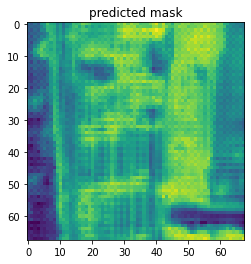

In [14]:
learning.predict_segmentation(idx=0)